# 5. Scattering coefficients reconstruction

After retrieving the most relevant features with an ICA from the scattering coefficients, we can now check what these features are actually telling us.

In [16]:
import pickle

import numpy as np
import matplotlib.pylab as plt

In [17]:
%config InlineBackend.figure_format = "svg"

## Load the data

For this notebook we need to load the scattering network model, the dimensionality reduction model and the independent components.

In [18]:
# Load the scattering network
network = pickle.load(open("../example/scattering_network.pickle", "rb"))

# Load the dimensionality reduction model
dimension_model = pickle.load(open("../example/dimension_model.pickle", "rb"))

# Load data from file
with np.load(
    "../example/independent_components.npz", allow_pickle=True
) as data:
    features = data["features"]
    times = data["times"]

## Reconstruct scattering coefficients from one feature

FastICA finds a set of independent components $\mathbf{s}$ by multiplying an unmixing matrix $\mathbf{W}$ to the scattering coefficients stored in the matrix $\mathbf{x}$: 

$$\mathbf{s} = \mathbf{W} \mathbf{x}$$

The FastICA model stores the unmixing matrix $\mathbf{W}$ in the attribute `.components_`. We can extract the weights of the unmixing matrix and visualize it to understand better what each independent component means, since it connects the scattering coefficients to the independent components.

To give an example on how to use the information of the unmixing matrix, we choose one single independent component and extract the unmixing weights for that component. The feature we have chosen represents the evolution of the tremor signal over the day. Note that the sign of a feature is arbitrary—a negative or positive change in the feature amplitude means only a relative change. Without the unmixing weights we cannot tell if the feature amplitude change is related to an amplitude increase or decrease in the scattering coefficient matrix.

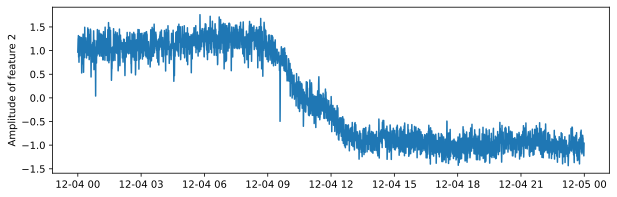

In [19]:
# Pick a feature
feature_id = 2
feature = features[:, feature_id]

# Figure creation
fig = plt.figure(figsize=(10, 3))
ax = plt.axes()

# Plot the weights
ax.plot(times, feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")

# Show
plt.show()

## Visualize feature direction in scattering space

The top row shows the unmixing weights for the first-order scattering coefficients, which all show negative values with a minimum at a first-order frequency $f_1$ of 2 Hz. The bottom row shows the unmixing weights for the second-order coefficients, which show both positive and negative values.

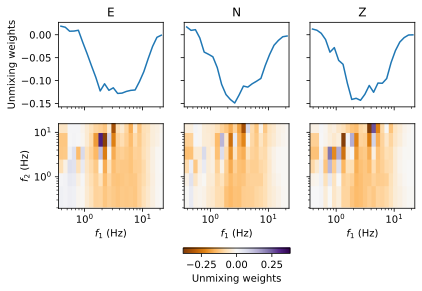

In [20]:
# Etract weights from the dimensionality reduction model
weights = dimension_model.components_[feature_id]
vmax = np.abs(weights).max()

# Scattering coefficients shape and frequencies
n_cha = 3
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_2 = network.banks[1].octaves * network.banks[1].resolution
f_1 = network.banks[0].centers
f_2 = network.banks[1].centers

# Extract and reshape weights
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)
order_2 = weights[n_cha * n_order_1 :].reshape(n_cha, n_order_1, n_order_2)

# Show weights
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey="row")
image_kw = dict(vmin=-vmax, vmax=vmax, rasterized=True, cmap="PuOr")
for id, channel in enumerate("ENZ"):

    # Show
    ax[0, id].plot(f_1, order_1[id], label=channel)
    mappable = ax[1, id].pcolormesh(f_1, f_2, order_2[id].T, **image_kw)

    # Labels
    ax[0, id].set_title(channel)
    ax[1, id].set_xlabel("$f_1$ (Hz)")

# Labels
ax[0, 0].set_ylabel("Unmixing weights")
ax[1, 0].set_ylabel("$f_2$ (Hz)")
ax[1, 0].set_xscale("log")
ax[1, 0].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="horizontal", ax=ax, shrink=0.3)
colorbar.set_label("Unmixing weights")

# Show
plt.show()

## Interpret partial reconstruction

We here reconstruct the scattering coefficients from a selected independent component. We only show the first order coefficients, since the second order coefficients are hard to map as a function of time. 

The reconstruction shows clearly the evolving tremor signal, starting between 9:00 and 12:00. The tremor signal is characterized by an increased amplitude peaking around 2 Hz. The negative values in the unmixing matrix were applied to the scattering coefficients matrix to retrieve feature 2, tracking the tremor onset with an amplitude decrease in the feature. If feature 2 would track the tremor signal with an amplitude increase, the weights in the unmixing matrix would have had the opposite sign.

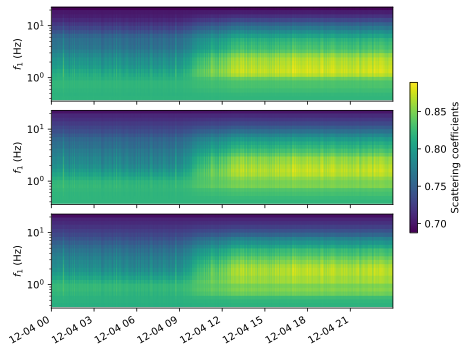

In [21]:
# Filter out latent space
features_filtered = np.zeros(features.shape)
features_filtered[:, feature_id] = feature

# Extract all scattering coefficients
reconstructed = dimension_model.inverse_transform(features_filtered)
reconstructed_order_1 = reconstructed[:, : n_cha * n_order_1].reshape(
    -1, n_cha, n_order_1
)
vmin = reconstructed_order_1.min()
vmax = reconstructed_order_1.max()

# Plot
fig, ax = plt.subplots(
    nrows=3, sharex=True, sharey="row", constrained_layout=True
)

# Plot
for id, channel in enumerate("ENZ"):
    data = reconstructed_order_1[:, id, :].squeeze().T
    mappable = ax[id].pcolormesh(
        times, f_1, data, rasterized=True, vmin=vmin, vmax=vmax
    )
    ax[id].set_ylabel("$f_1$ (Hz)")
    ax[id].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="vertical", ax=ax, shrink=0.5)
colorbar.set_label("Scattering coefficients")
fig.autofmt_xdate()